<a href="https://colab.research.google.com/github/HenryJi529/ColabNotebooks/blob/main/PracticePyG1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 点分类任务

In [1]:
# %%capture
!pip install SciencePlots
!pip install powerlaw
!pip install torchmetrics
!pip install torchinfo
!pip install -U mlxtend
!pip install torch_geometric
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html

from IPython.display import clear_output
clear_output()

In [41]:
import matplotlib as mpl
from matplotlib import pyplot as plt
# 'serif', 'sans-serif', 'monospace', 'fantasy', 'cursive'
cnFont = {'fontname':'Songti SC', 'color':'darkred', 'weight':'bold', 'size': 30}
# plt.rcParams['figure.dpi'] = 400
# plt.rcParams['savefig.bbox'] = 'tight'
import seaborn as sns
import scienceplots


import numpy as np
np.random.seed(520)
from scipy import stats, optimize
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from pandas import Series,DataFrame
# pd.set_option('display.max_columns',100)
# pd.set_option('display.max_rows',100)


import networkx as nx
import powerlaw


from typing import Tuple, Dict, List
import os
import time, datetime
import random
from pathlib import Path
import requests, zipfile
from tqdm.auto import tqdm
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.nn import functional as F
from torchmetrics import Accuracy, ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
from torchinfo import summary
from PIL import Image
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

import torch_geometric
from torch_geometric import datasets, transforms
from torch_geometric.utils import to_networkx
from torch_geometric.nn import GCNConv, Linear

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32
     

In [42]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

In [43]:
dataset = Planetoid(root="data/Planetoid", name="Cora", transform=NormalizeFeatures())

In [44]:
len(dataset)

1

In [45]:
data = dataset[0]
dataset.num_classes, dataset.num_edge_features, dataset.num_node_features,

(7, 0, 1433)

In [46]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [47]:
def visualize(featureVector, color):
  reducedFeatureVector = TSNE(n_components=2). \
    fit_transform(featureVector.detach().cpu().numpy())
  with plt.style.context('ggplot'):
    plt.scatter(reducedFeatureVector[:,0], reducedFeatureVector[:,1], c=color, cmap=plt.cm.cool)

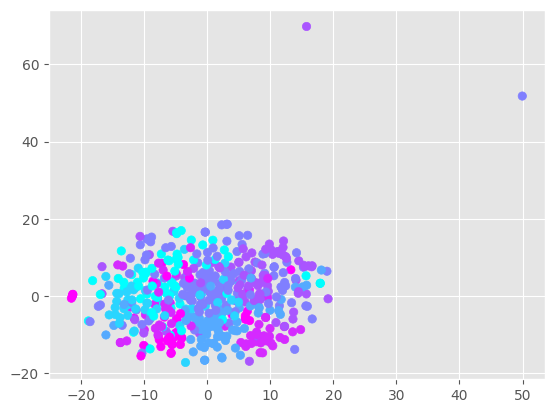

In [61]:
visualize(data.x[:500], data.y[:500])

## 对比 MLP 和 GNN

### MLP

In [49]:
class MLP(torch.nn.Module):
  def __init__(self, hidden_units):
    super().__init__()
    self.linear_layer1 = Linear(dataset.num_features, hidden_units)
    self.linear_layer2 = Linear(hidden_units, dataset.num_classes)
  
  def forward(self, x):
    return self.linear_layer2(F.dropout(torch.relu(self.linear_layer1(x)), p=0.5))


In [50]:
model0 = MLP(hidden_units=16)
summary(model=model0)

Layer (type:depth-idx)                   Param #
MLP                                      --
├─Linear: 1-1                            22,944
├─Linear: 1-2                            119
Total params: 23,063
Trainable params: 23,063
Non-trainable params: 0

In [51]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model0.parameters(), lr=0.01, weight_decay=1e-4)

def train_step(model: torch.nn.Module, data):
  model.train()
  y_pred_logits = model(data.x)
  loss = loss_fn(y_pred_logits[data.train_mask], data.y[data.train_mask])
  y_pred_label = y_pred_logits.argmax(dim=1)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  acc = (y_pred_label[data.train_mask]==data.y[data.train_mask]).sum()/len(data.y[data.train_mask])

  return loss.item(), acc.item()

def val_step(model: torch.nn.Module, data):
  model.eval()
  with torch.inference_mode():
    y_pred_logits = model(data.x)
    loss = loss_fn(y_pred_logits[data.val_mask], data.y[data.val_mask])
    y_pred_label = y_pred_logits.argmax(dim=1)
    acc = (y_pred_label[data.val_mask]==data.y[data.val_mask]).sum()/data.val_mask.sum()

    return loss.item(), acc.item()


epochs = 1000
results = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": []
}

for epoch in tqdm(range(epochs)):
  train_loss, train_acc = train_step(model0, data)
  val_loss, val_acc = val_step(model0, data)
  results["train_loss"].append(train_loss)
  results["val_loss"].append(val_loss)
  results["train_acc"].append(train_acc)
  results["val_acc"].append(val_acc)

  0%|          | 0/1000 [00:00<?, ?it/s]

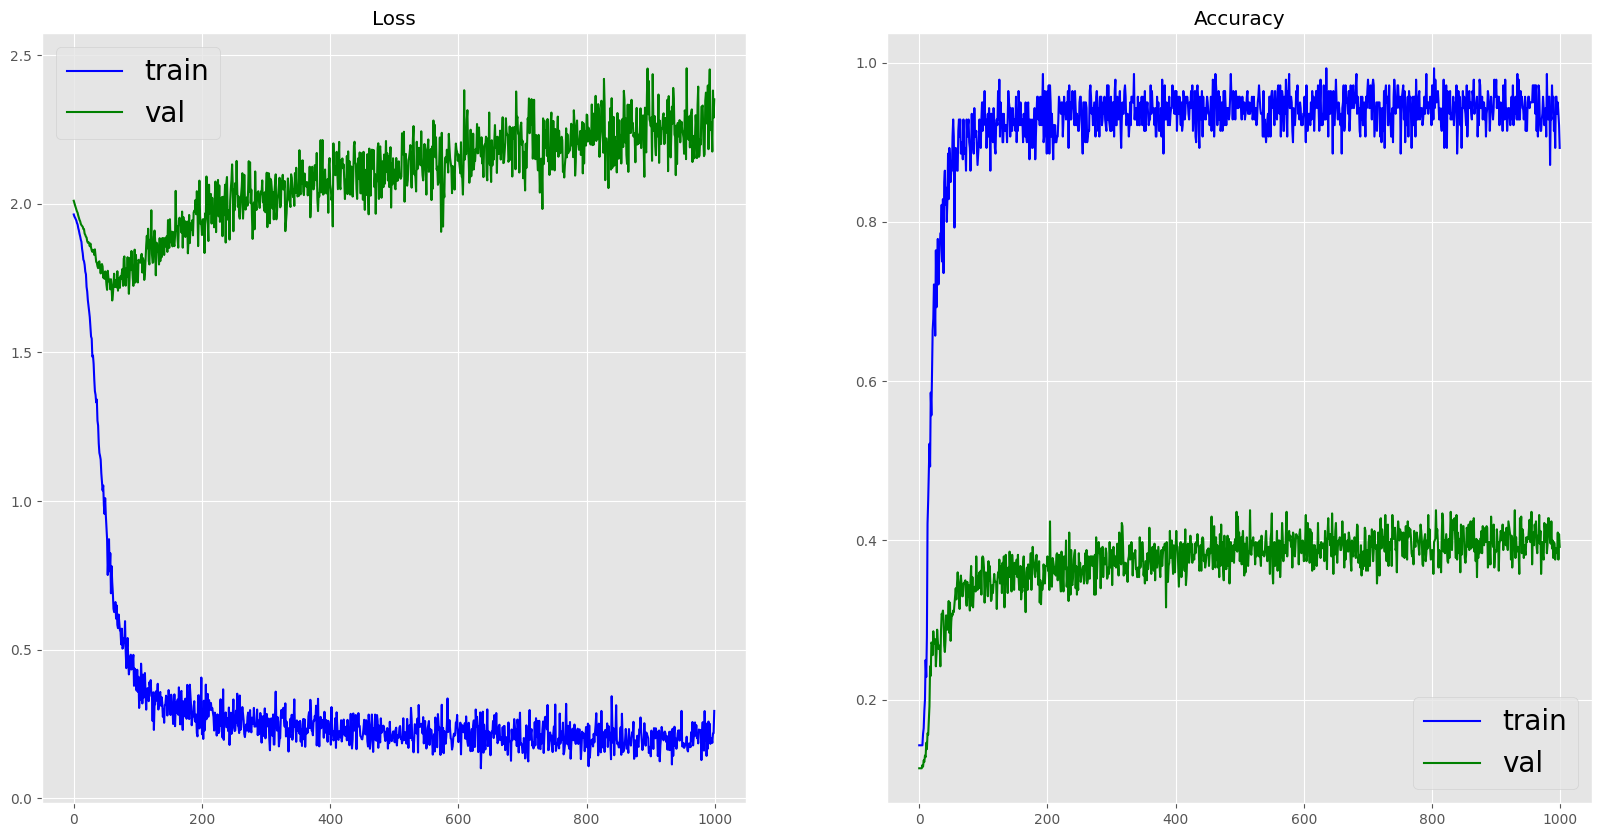

In [52]:
with plt.style.context('ggplot'):
  fig, axes = plt.subplots(1,2, figsize=(20,10))
  axes[0].plot(results["train_loss"], c='b', label="train")
  axes[0].plot(results["val_loss"], c='g', label="val")
  axes[0].set_title('Loss')
  axes[0].legend(fontsize=20)
  axes[1].plot(results["train_acc"], c='b', label="train")
  axes[1].plot(results["val_acc"], c='g', label="val")
  axes[1].set_title('Accuracy')
  axes[1].legend(fontsize=20)

### GNN

In [57]:
class GCN(torch.nn.Module):
  def __init__(self, hidden_units):
    super().__init__()
    self.conv1 = GCNConv(dataset.num_features, hidden_units)
    self.conv2 = GCNConv(hidden_units, dataset.num_classes)

  def forward(self, x, edge_index):
    logits = self.conv2(torch.relu(self.conv1(x, edge_index)), edge_index)
    return logits

In [58]:
model1 = GCN(hidden_units=16)
summary(model1)

Layer (type:depth-idx)                   Param #
GCN                                      --
├─GCNConv: 1-1                           16
│    └─SumAggregation: 2-1               --
│    └─Linear: 2-2                       22,928
├─GCNConv: 1-2                           7
│    └─SumAggregation: 2-3               --
│    └─Linear: 2-4                       112
Total params: 23,063
Trainable params: 23,063
Non-trainable params: 0

In [59]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.01, weight_decay=1e-4)

def train_step(model: torch.nn.Module, data):
  model.train()
  y_pred_logits = model(data.x, data.edge_index)
  loss = loss_fn(y_pred_logits[data.train_mask], data.y[data.train_mask])
  y_pred_label = y_pred_logits.argmax(dim=1)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  acc = (y_pred_label[data.train_mask]==data.y[data.train_mask]).sum()/len(data.y[data.train_mask])

  return loss.item(), acc.item()

def val_step(model: torch.nn.Module, data):
  model.eval()
  with torch.inference_mode():
    y_pred_logits = model(data.x, data.edge_index)
    loss = loss_fn(y_pred_logits[data.val_mask], data.y[data.val_mask])
    y_pred_label = y_pred_logits.argmax(dim=1)
    acc = (y_pred_label[data.val_mask]==data.y[data.val_mask]).sum()/data.val_mask.sum()

    return loss.item(), acc.item()


epochs = 1000
results = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": []
}

for epoch in tqdm(range(epochs)):
  train_loss, train_acc = train_step(model1, data)
  val_loss, val_acc = val_step(model1, data)
  results["train_loss"].append(train_loss)
  results["val_loss"].append(val_loss)
  results["train_acc"].append(train_acc)
  results["val_acc"].append(val_acc)

  0%|          | 0/1000 [00:00<?, ?it/s]

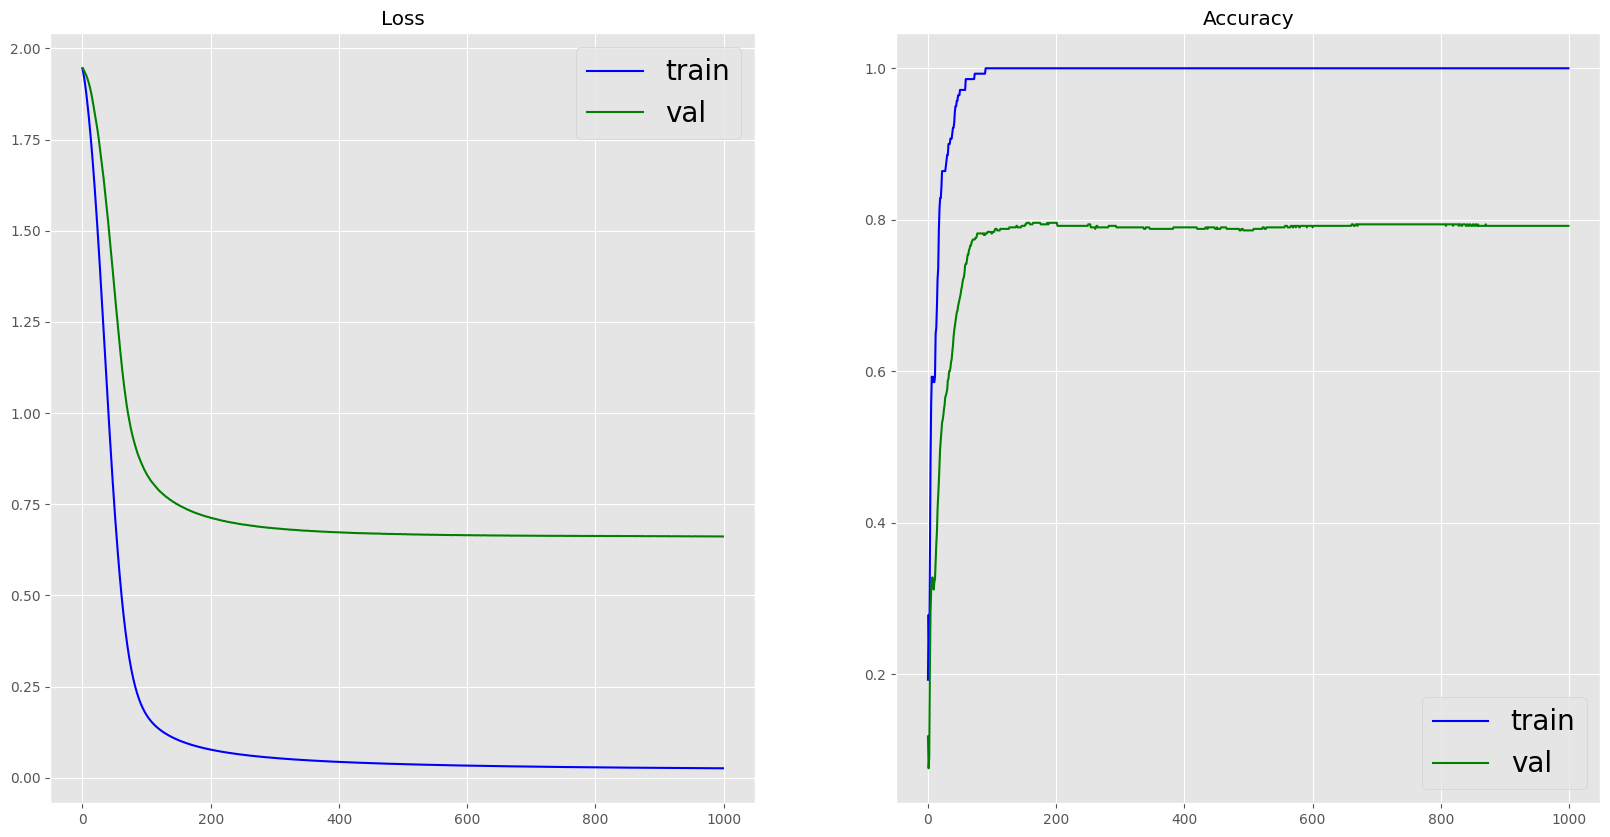

In [60]:
with plt.style.context('ggplot'):
  fig, axes = plt.subplots(1,2, figsize=(20,10))
  axes[0].plot(results["train_loss"], c='b', label="train")
  axes[0].plot(results["val_loss"], c='g', label="val")
  axes[0].set_title('Loss')
  axes[0].legend(fontsize=20)
  axes[1].plot(results["train_acc"], c='b', label="train")
  axes[1].plot(results["val_acc"], c='g', label="val")
  axes[1].set_title('Accuracy')
  axes[1].legend(fontsize=20)